In [8]:
import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer

import pygame
import numpy as np

import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import gym
import matplotlib.pyplot as plt
import time

In [95]:
class SimpleCorridor(gym.Env):
    def __init__(self, config):
        self.end_pos = config["corridor_length"]
        self.cur_pos = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(0.0, self.end_pos, shape=(1,))

    def reset(self):
        self.cur_pos = 0
        return [self.cur_pos]

    def step(self, action):
        if action == 0 and self.cur_pos > 0: # walk left
            self.cur_pos -= 1
        if action == 1:
            self.cur_pos += 1
        done = self.cur_pos >= self.end_pos
        reward = 1.0 if done else -0.1
        return [self.cur_pos], reward, done, {} 
    def render(self, mode="rgb_array"):
#        print("current state: ", self.cur_pos)
        canvas = pygame.Surface((20, 20*self.end_pos+1))
        canvas.fill((255, 255, 255))
        for i in range(self.end_pos+2):
            pygame.draw.line(canvas, 0, (0, 20*(i)), (20, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (0,0), (0, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (19,0), (19, 20*(i)), width=1)
        pygame.draw.circle(canvas, (0, 0, 255), (10,self.cur_pos*20+10), 7)
        pygame.draw.circle(canvas, (255, 0, 0), (10,(self.end_pos-1)*20+10), 7)
        
        plArray = np.array(pygame.surfarray.pixels3d(canvas))
        plt.imshow(plArray)        
        plt.axis("off")

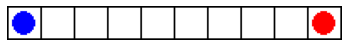

In [96]:
env = SimpleCorridor({"corridor_length": 10})
env.reset()
env.render()

In [97]:
env.end_pos

10

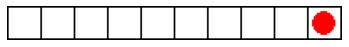

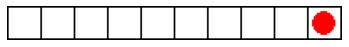

In [102]:
env.reset()
done = False

while not done:
    display.clear_output(wait=True)

    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.01)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()

In [ ]:
trainer = DQNTrainer(
    config={
        "env": SimpleCorridor,
        "framework": "torch",
        "env_config": {
            "corridor_length": 20
        },
        "num_workers": 4
    }
)

In [ ]:
for i in range(50):
    
    results = trainer.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")


In [ ]:
trainer.config

In [108]:
env = SimpleCorridor({"corridor_length": 20})
# Get the initial observation (should be: [0.0] for the starting position).
obs = env.reset()
done = False
total_reward = 0.0
# Play one episode.
while not done:
    env.render()
    
    action = trainer.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    time.sleep(1)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()
# Report results.
print(f"Played 1 episode; total-reward={total_reward}")

Played 1 episode; total-reward=-0.9000000000000006


In [119]:
trainer.stop()

In [109]:
!pwd

/home/ajit.kumar@SNU.IN/Desktop/udemy-rl/rLibTesting
